In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import torch
import torch.nn as nn
import torch.optim as optim

In [9]:

# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the Berger Viscous Equation parameters
c = 1.0    # Wave speed
mu = 0.1   # Viscosity coefficient
lam = 1.0  # Nonlinearity coefficient

# Define the neural network
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.net = nn.Sequential(*[
            nn.Sequential(nn.Linear(layers[i], layers[i+1]), nn.Tanh())
            for i in range(len(layers)-2)
        ] + [nn.Linear(layers[-2], layers[-1])])

    def forward(self, x, t):
        inputs = torch.cat((x, t), dim=1)
        return self.net(inputs)

# Compute PDE residual using automatic differentiation
def compute_pde_residual(model, x, t):
    x = x.clone().detach().requires_grad_(True)
    t = t.clone().detach().requires_grad_(True)

    u = model(x, t)  # Predict u(x, t)
    
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_tt = torch.autograd.grad(u_t, t, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u), create_graph=True, retain_graph=True)[0]

    f = u_tt - c**2 * u_xx - mu * u_xx + lam * u * u_xx  # PDE residual
    return f

# Importance sampling: Generate collocation points based on residuals
# def generate_collocation_points(model, N_f, L=1.0, T=1.0):
#     x_f = torch.rand(N_f, 1, device=device, requires_grad=True) * L  # x in [0, L]
#     t_f = torch.rand(N_f, 1, device=device, requires_grad=True) * T  # t in [0, T]
    
#     if model is not None:  # Perform importance sampling
#         residuals = compute_pde_residual(model, x_f, t_f).detach()
#         probabilities = residuals.abs() / torch.sum(residuals.abs())  # Normalize to form a probability distribution
#         sampled_indices = torch.multinomial(probabilities.view(-1), N_f, replacement=True)
#         x_f, t_f = x_f[sampled_indices], t_f[sampled_indices]
    
#     return x_f, t_f


# # Training loop with dynamic importance sampling




In [10]:
def fit_GP(x,t):
    kernel = C(1.0) * RBF(length_scale=1.0)

# Create the Gaussian Process Regressor
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    x_0 = x.cpu().detach().numpy() 
    t_0 = t.cpu().detach().numpy()
    gp.fit(x_0,t_0)
    y_pred, sigma = gp.predict(x_0, return_std=True)
    
    most_uncertain_indices = np.argsort(-sigma)[:100]  # Sort in descending order and take top 100
    most_uncertain_points = x_0[most_uncertain_indices]

    most_uncertain_indices = torch.tensor(most_uncertain_points,device=device, requires_grad=True)
    most_uncertain_points=torch.tensor(most_uncertain_points, device=device, requires_grad=True)
    return most_uncertain_points,most_uncertain_indices
    



In [11]:
def fit_GP(model,x,t):
    # Evaluate residuals at collocation points
    residuals = compute_pde_residual(model,x, t).cpu().detach().numpy()

# Convert collocation points to NumPy for sklearn GP
    collocation_np = np.hstack((x.cpu().detach().numpy(), t.cpu().detach().numpy()))

# Define Gaussian Process kernel (constant term + RBF)
    kernel = C(1.0, (1e-2, 1e2)) * RBF(length_scale=0.5, length_scale_bounds=(1e-2, 1e2))

# Fit Gaussian Process to residuals
    gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, n_restarts_optimizer=5)
    gp.fit(collocation_np, residuals)

    print("GP Training Done!")
    return gp



In [12]:
def gen_Hi_Points(model,x,t):
    # Generate dense evaluation grid for GP
    gp = fit_GP(model,x,t)
    x_dense = np.linspace(-1, 1, 50).reshape(-1, 1)
    t_dense = np.linspace(0, 1, 50).reshape(-1, 1)
    X, T = np.meshgrid(x_dense, t_dense)
    dense_points = np.hstack((X.reshape(-1, 1), T.reshape(-1, 1)))

    # Predict residual variance using GP
    residual_mean, residual_std = gp.predict(dense_points, return_std=True)

    # Identify high-uncertainty regions
    high_var_indices = np.argsort(residual_std)[-100:]  # Select top 10 uncertain points
    new_points = torch.tensor(dense_points[high_var_indices], dtype=torch.float32)

    # Split x and t for the new points
    x_new = new_points[:, 0].reshape(-1, 1).to(device)

    t_new = new_points[:, 1].reshape(-1, 1).to(device)


    # Merge with existing collocation points
    x_collocation = torch.cat([x.to(device), x_new]).to(device)
    t_collocation = torch.cat([t.to(device), t_new]).to(device)


    print("Updated Collocation Points with GP Guidance!")
    return x_collocation, t_collocation

In [13]:
# Define loss function
def loss_function(model, x_f, t_f, x_bc, t_bc, u_bc):
    f_residual = compute_pde_residual(model, x_f, t_f)
    loss_pde = torch.mean(f_residual**2)

    u_pred_bc = model(x_bc, t_bc)
    loss_bc = torch.mean((u_pred_bc - u_bc)**2)

    return loss_pde + loss_bc
    
def train(model, optimizer, N_f, x_bc, t_bc, u_bc, epochs=5000, resample_every=500):
    x_f, t_f = generate_collocation_points(model, N_f)
    for epoch in range(epochs): 
        optimizer.zero_grad()
        loss = loss_function(model, x_f, t_f, x_bc, t_bc, u_bc)
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            # x_f,t_f = fit_GP(x_f,t_f)
            print(f"Epoch {epoch}, Loss: {loss.item()}")
            x_uncertain, t_uncertain = gen_Hi_Points(model,x_f, t_f) 
            x_f = x_uncertain
            t_f = t_uncertain

In [14]:
# Define PINN model architecture
layers = [2, 50, 50, 50, 1]  # Input (x,t) -> Hidden layers -> Output (u)
model = PINN(layers).to(device)

# Define boundary and initial conditions
N_f = 1000  # Collocation points
L, T = 1.0, 1.0  # Spatial and time limits

x_f, t_f = generate_collocation_points(None, N_f, L, T)  # Initial uniform sampling

# Boundary conditions (u(x, 0) = sin(pi x), u(0, t) = 0, u(L, t) = 0)
N_bc = 100
x_bc = torch.linspace(0, L, N_bc).view(-1, 1).to(device)
t_bc = torch.zeros_like(x_bc).to(device)
u_bc = torch.sin(np.pi * x_bc.cpu()).to(device)  # Initial condition

# Train the model with importance sampling
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train(model, optimizer, N_f, x_bc, t_bc, u_bc, epochs=10000, resample_every=100)

# Visualize results
x_test = torch.linspace(0, L, 100).view(-1, 1).to(device)
t_test = torch.linspace(0, T, 100).view(-1, 1).to(device)

x_grid, t_grid = torch.meshgrid(x_test.squeeze(), t_test.squeeze(), indexing='ij')
x_flat, t_flat = x_grid.flatten().view(-1, 1), t_grid.flatten().view(-1, 1)

u_pred = model(x_flat, t_flat).detach().cpu().numpy().reshape(100, 100)

NameError: name 'generate_collocation_points' is not defined

In [15]:
#Loss on general function
x_f, t_f = generate_collocation_points(model, 1000,L,T)
x_bc = torch.linspace(0, L, N_bc).view(-1, 1).to(device)
t_bc = torch.zeros_like(x_bc).to(device)
u_bc = torch.sin(np.pi * x_bc.cpu()).to(device)

loss_function(model, x_f, t_f, x_bc, t_bc, u_bc).item()

NameError: name 'generate_collocation_points' is not defined

/home/cadmin/anaconda3/envs/Data_Science_V2/lib/python3.11/site-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


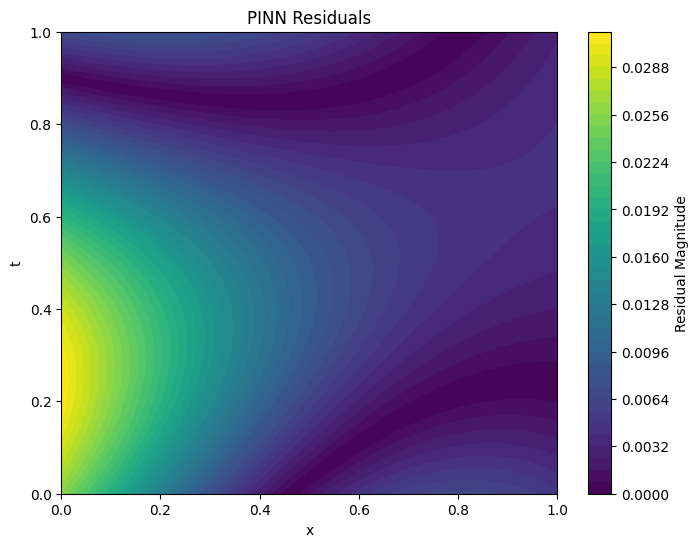

In [16]:
def plot_residuals(model, x_range=(0, 1), t_range=(0, 1), num_points=100):
    x_test = torch.linspace(x_range[0], x_range[1], num_points).view(-1, 1).to(device)
    t_test = torch.linspace(t_range[0], t_range[1], num_points).view(-1, 1).to(device)

    x_grid, t_grid = torch.meshgrid(x_test.squeeze(), t_test.squeeze(), indexing='ij')
    x_flat, t_flat = x_grid.flatten().view(-1, 1), t_grid.flatten().view(-1, 1)

    residuals = compute_pde_residual(model, x_flat, t_flat).detach().cpu().numpy().reshape(num_points, num_points)

    plt.figure(figsize=(8, 6))
    plt.contourf(x_grid.cpu().numpy(), t_grid.cpu().numpy(), np.abs(residuals), levels=50, cmap="viridis")
    plt.colorbar(label="Residual Magnitude")
    plt.xlabel("x")
    plt.ylabel("t")
    plt.title("PINN Residuals")
    plt.show()

# Call the function to visualize residuals
plot_residuals(model)